### Compare the performance of GPUCB and QuantUCB on toy data

Cheng: There is a bandit algorithm, called GP-UCB, which looks at estimating the upper confidence bound using Gaussian processes, and then choosing the point that maximises the UCB as the point to sample. The idea is to do Quant-UCB, which is to use a quantile (e.g. 90%) instead of the Gaussian variance.

This notebook is to compare the performance of GPUCB and QuantUCB.

The data is generated from sin distribution with normal noise. [TODO: other datasets (optwok)]
 
The initial setting is for GPUCB, we fix the adjusting parameter beta. [TODO: use the beta formula specified in papers]

For QuantUCB, there is two ideas for finding the point to observe:

(1) find the index which returns the maximum uppper bound. The upper bound is specified by the upper quantile, which changes along epoches: argmax $\tau_{q(t)} (x)$ 

(2) Similar to GPUCB, we also consider the predictions (median) and variance (e.g. (upper bound - lower bound)/2):
argmax $\mu(x) + \beta_t \frac{1}{2} (uq - lq)$

[TODO: figure out how the upper quantile or beta changes.]

[TODO: Kernel quantile regression optimization cross problem]

In [1]:
# coding: utf-8
import numpy as np
from matplotlib import pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.kernel_approximation
import scipy.optimize as opt
import UCB
from UCB import DummyEnvironment
from statsmodels.regression.quantile_regression import QuantReg
from pickle import load
import bz2
%matplotlib inline

(20,)

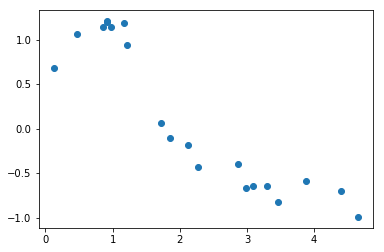

In [2]:
num_ex = 20
f = bz2.BZ2File('gaussproc_06_20_0.1.pkl', 'rb')
data = load(f, encoding='latin1')
x = data.examples[0][:20]
t = data.labels[:20]
plt.scatter(x,t)
x.shape

1
0.069314718056
2
0.179175946923
3
0.248490664979
4
0.299573227355
5
0.340119738166
6
0.373766961828
7
0.402535169074
8
0.427666611902
9
0.449980967033
10
0.470048036579
11
0.488280192259
12
0.504985600725
13
0.520400668708
14
0.534710753072
15
0.548063892334
16
0.56058020663
17
0.572358510195
18
0.583481073706
19
0.594017125272
(66,)
(66,)


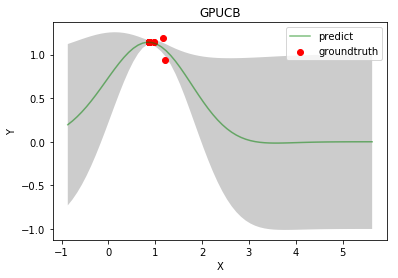

In [3]:
# perform GPUCB and plot the predictions with samples

alpha = 0.01 
GPAgent = UCB.GPUCB(x, t, alpha)
for i in range(20):
    GPAgent.learn(i) 
GPAgent.plot()

In [14]:
x = np.arange(-3, 3, 0.1)
env = DummyEnvironment()
t = env.sin_sample(x)
x.shape
t.shape

(60,)

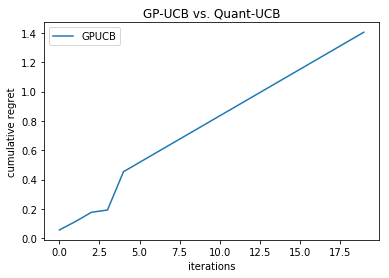

In [4]:
plt.plot(range(20), GPAgent.regret_list, label = 'GPUCB')
plt.xlabel('iterations')
plt.ylabel('cumulative regret')
plt.title('GP-UCB vs. Quant-UCB')
plt.legend()

         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 4588
         Gradient evaluations: 88
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 11192
         Gradient evaluations: 215
         Current function value: 0.119261
         Iterations: 3
         Function evaluations: 6408
         Gradient evaluations: 123
         Current function value: 0.065835
         Iterations: 4
         Function evaluations: 6564
         Gradient evaluations: 126
         Current function value: 0.137441
         Iterations: 9
         Function evaluations: 7656
         Gradient evaluations: 147
         Current function value: 0.137357
         Iterations: 10
         Function evaluations: 7656
         Gradient evaluations: 147
         Current function value: 0.147313
         Iterations: 4
         Function evaluations: 6304
         Gradient evaluations: 121
         Current function value: 0.177477
    

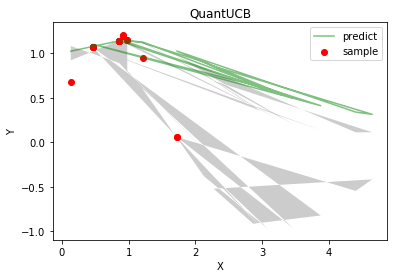

In [5]:
# perform QuantUCB with uq increasing by 0.001 per epoch

uq = 0.85
lq = 0.1
QuantAgent = UCB.QuantUCB(x, t, uq, lq)
for i in range(20):
    QuantAgent.learn()
QuantAgent.plot() 

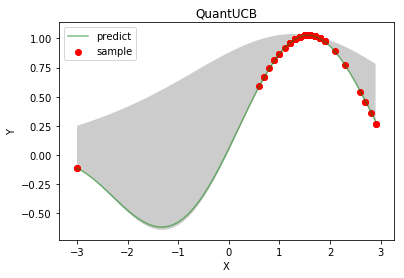

In [7]:
# perform QuantUCB with uq fixed at 0.8 

uq = 0.85
lq = 0.1
QuantAgent_noincrease = UCB.QuantUCB(x, env, uq, lq, uq_rate=0.0)
for i in range(200):
    QuantAgent_noincrease.learn()
QuantAgent_noincrease.plot()

In [8]:
# perform QuantUCB for 10 times and take avarage

num_test = 10
num_iter = 200

Quant_regret = np.zeros((num_iter))
Quant_regret_noinc = np.zeros((num_iter))

for i in range(num_test):
    uq = 0.8
    lq = 0.1
    
    # increase uq with rate 0.001
    QuantAgent = UCB.QuantUCB(x, env, uq, lq)
    for i in range(num_iter):
        QuantAgent.learn()
    Quant_regret += QuantAgent.regret_list
    
    # no increase
    QuantAgent_noincrease = UCB.QuantUCB(x, env, uq, lq, uq_rate=0.0)
    for i in range(200):
        QuantAgent_noincrease.learn()
    Quant_regret_noinc += QuantAgent_noincrease.regret_list
    
Quant_regret = Quant_regret/num_test
Quant_regret_noinc = Quant_regret_noinc/num_test
    

### Setting:

GPUCB: fixed beta (1.0)  
QuantUCB: idea (1) with increasing upper quantiles (from 0.8 to 0.95)  
QuantUCB NoInc: idea (1) with fixed upper quantiles (0.8)

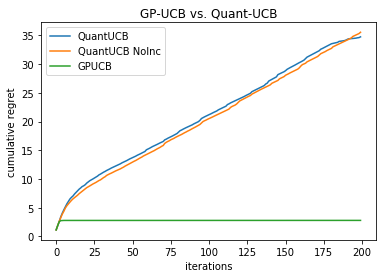

In [9]:
#plot cumulative regret

#plt.plot(range(200), QuantAgent.regret_list, label = 'QuantUCB')
#plt.plot(range(200), QuantAgent_noincrease.regret_list, label = 'QuantUCB NoInc')

plt.plot(range(200), Quant_regret, label = 'QuantUCB')
plt.plot(range(200), Quant_regret_noinc, label = 'QuantUCB NoInc')
plt.plot(range(200), GPAgent.regret_list, label = 'GPUCB')
plt.xlabel('iterations')
plt.ylabel('cumulative regret')
plt.title('GP-UCB vs. Quant-UCB')
plt.legend()

In [ ]:
X = np.asarray(QuantAgent.X)
X = X.reshape(X.shape[0],1)

T = np.asarray(QuantAgent.T)
T = T.reshape(T.shape[0],1)

import pandas as pd

data = pd.DataFrame(data = np.hstack([X, T]), columns = ['x', 'y'])
data.head()